# **윤슬의 잔물결✨**

[[윤슬🌊] 퇴근시간 버스승차인원 예측 경진대회 Stage 1: 데이터 불러오기](https://dacon.io/competitions/official/236047/codeshare/7455?page=1&dtype=random)
</br>[[윤슬🌊] 퇴근시간 버스승차인원 예측 경진대회 Stage 2: 데이터 전처리 및 모델링](https://dacon.io/codeshare/7655)
</br>[[윤슬🌊] 퇴근시간 버스승차인원 예측 경진대회 Stage 3: 시각화 및 모델링](https://dacon.io/competitions/official/236047/codeshare/7656)
</br>[[윤슬🌊] 퇴근시간 버스승차인원 예측 경진대회 Stage 4: 고급 시각화 및 스케일링](https://dacon.io/competitions/official/236047/codeshare/7657?page=1&dtype=random)
</br>[[윤슬🌊] 퇴근시간 버스승차인원 예측 경진대회 Stage 5: 외부 데이터 활용 및 모델링](https://dacon.io/competitions/official/236047/codeshare/7658?page=1&dtype=random)

<br/>
<div style="text-align: right"> 23-02-12 | ver.006 </div>

---



분석을 시작하기에 앞서 사용했던 라이브러리와 데이터를 불러오겠습니다😊

> 라이브러리 호출

In [ ]:
pip install geopandas  ## geopandas 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 6.6 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

# 고급 시각화
import geopandas as gpd
import pyproj
from fiona.crs import from_epsg

# 스케일링
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#한글깨짐
plt.rc('font', family = 'NanumBarunGothic')

> 데이터 불러오기

In [ ]:
train = pd.read_csv('train.csv' ,index_col=0)
test = pd.read_csv('test.csv', index_col=0)
bus = pd.read_csv('bus_bts.csv' ,index_col=0)
submission = pd.read_csv('submission_sample.csv', index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> 전처리

In [ ]:
#train 카피
train1=train.copy()

# train 데이터셋 전처리
train = train.replace('시내', 0)
train = train.replace('시외', 1)

train = train.drop(['station_name'], axis = 1)

train['date'] = pd.to_datetime(train['date'])
train['date'] = train['date'].dt.weekday

train['6~8_ride']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['8~10_ride']=train['8~9_ride']+train['9~10_ride']
train['10~12_ride']=train['10~11_ride']+train['11~12_ride']

train['6~8_off']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['8~10_off']=train['8~9_takeoff']+train['9~10_takeoff']
train['10~12_off']=train['10~11_takeoff']+train['11~12_takeoff']

train=train.drop(['6~7_ride','7~8_ride','8~9_ride','9~10_ride','10~11_ride','11~12_ride',
              '6~7_takeoff','7~8_takeoff','8~9_takeoff','9~10_takeoff','9~10_takeoff','10~11_takeoff','11~12_takeoff'],axis=1)

In [ ]:
#test 카피
test1=test.copy()

# test 데이터셋 전처리
test = test.replace('시외', 1)
test = test.replace('시내', 0)

test = test.drop(['station_name'], axis=1)

test['date'] = pd.to_datetime(test['date'])
test['date'] = test['date'].dt.weekday

test['6~8_ride']=test['6~7_ride']+test['7~8_ride'] # 6 ~ 8시 승차인원
test['8~10_ride']=test['8~9_ride']+test['9~10_ride']
test['10~12_ride']=test['10~11_ride']+test['11~12_ride']

test['6~8_off']=test['6~7_takeoff']+test['7~8_takeoff'] # 6 ~ 8시 하차인원
test['8~10_off']=test['8~9_takeoff']+test['9~10_takeoff']
test['10~12_off']=test['10~11_takeoff']+test['11~12_takeoff']


test=test.drop(['6~7_ride','7~8_ride','8~9_ride','9~10_ride','10~11_ride','11~12_ride',
              '6~7_takeoff','7~8_takeoff','8~9_takeoff','9~10_takeoff','9~10_takeoff','10~11_takeoff','11~12_takeoff'],axis=1)

In [ ]:
x = train[['date', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude',
       "6~8_ride",  "8~10_ride", "10~12_ride" , 
       "6~8_off", "8~10_off",  "10~12_off"]]

y = train['18~20_ride']

> 지도 시각화

In [ ]:
jeju_bus = gpd.points_from_xy(train.longitude, train.latitude)
jeju_bus[0:3]

<GeometryArray>
[<POINT (126.494 33.49)>, <POINT (126.485 33.489)>, <POINT (126.474 33.482)>]
Length: 3, dtype: geometry

In [ ]:
coulumns = ['18~20_ride', 'station_code','in_out']
jeju_bus = gpd.GeoDataFrame(train[coulumns], geometry=jeju_bus, crs=from_epsg(4326))
#df_cctv_gdf.info()
jeju_bus.head()

,18~20_ride,station_code,in_out,geometry
id,,,,
0,0.0,344,1,POINT (126.49373 33.48990)
1,5.0,357,1,POINT (126.48508 33.48944)
2,2.0,432,1,POINT (126.47352 33.48181)
3,53.0,1579,0,POINT (126.49252 33.50577)
4,0.0,1646,0,POINT (126.41260 33.25579)


<AxesSubplot:>

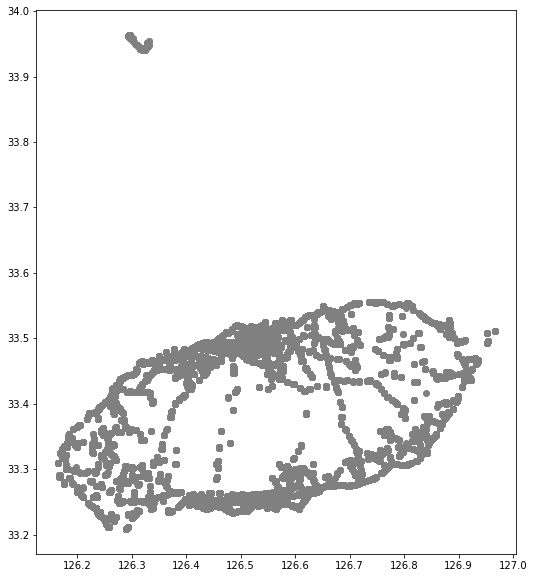

In [ ]:
jeju_bus2 = jeju_bus.to_crs(epsg=4326)
jeju_bus2.plot(color='gray', figsize=(10,10))

/usr/local/lib/python3.8/dist-packages/geopandas/array.py:938: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:939: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:940: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:941: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:410: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  warnings.warn(


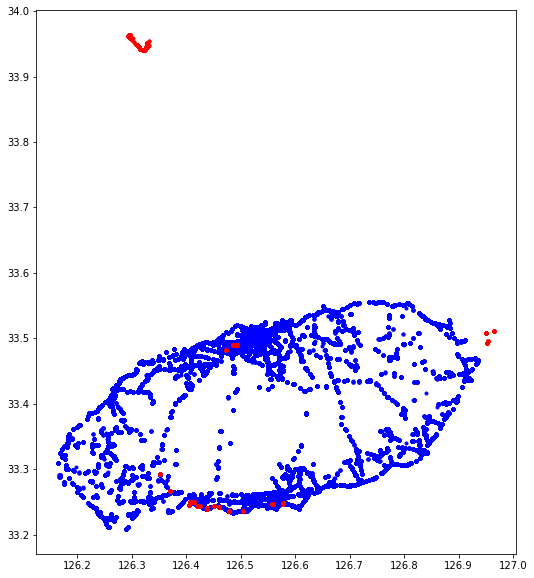

In [ ]:
ax=jeju_bus.boundary.plot(linewidth=1,color='black',figsize=(10,10))
jeju_bus[jeju_bus['in_out']==0].plot(ax=ax, color='blue',markersize=9) #시내
jeju_bus[jeju_bus['in_out']==1].plot(ax=ax, color='red',markersize=9) #시외
plt.show()

> 정규화

In [ ]:
# train 데이터셋 정규화
transformer = MinMaxScaler()
train11 = transformer.fit_transform(train[["date","bus_route_id", "in_out", "station_code",
                                            "6~8_ride", "8~10_ride" ,"10~12_ride", "6~8_off",  "8~10_off", "10~12_off"]])
train[["date","bus_route_id", "in_out", "station_code", 
        "6~8_ride", "8~10_ride" ,"10~12_ride", "6~8_off",  "8~10_off", "10~12_off"]] = train11

In [ ]:
# test 데이터셋 정규화
transformer = MinMaxScaler()
test11 = transformer.fit_transform(test[["date","bus_route_id", "in_out", "station_code", 
                                          "6~8_ride", "8~10_ride" ,"10~12_ride",  "6~8_off",  "8~10_off", "10~12_off"]])
test[["date","bus_route_id", "in_out", "station_code", 
      "6~8_ride", "8~10_ride" ,"10~12_ride",  "6~8_off",  "8~10_off", "10~12_off"]] = test11

이렇게 데이터를 불러왔으니, Stage5에서 사용했던 코드를 복습📌해보도록 하겠습니다

지도 시각화를 Stage4에서부터 시작해 5까지 왔습니다.(영차영차💦)
<br/>Stage4에서는 제주도내 시내/시외 버스를 구분한 단순한 시각화를 했었다면,
</br>Stage5에서는 Stage4에서 얻은 결과를 바탕으로 추가적인 전처리 작업을 해주었습니다.

1️⃣ 섬에만 다니는 버스노선 구분  
2️⃣ 날짜 데이터를 이용해 평일과 주말을 구분  
3️⃣ 공휴일 정보를 입력해 공휴일 구분  

바로 위와 같은 작업을 해주었죠!


우선, 제주도 외 시외 버스가 모여 있는 섬의 위치가 추자도와 우도인 정보를 얻어 
<br/>새로운 컬럼을 생성해 주었습니다.

<br/>외부 섬 위치 정보
<br/><font style="font-weight : bold">추자도</font> : 33.95175, 126.31156
<br/><font style="font-weight : bold">우도</font> : 33.50367, 126.95577

In [ ]:
# 추자도
train['island_1']=0

# 우도
train['island_2']=0

그리고 <font style="font-weight : bold">함수</font>를 정의해주었습니다.

In [ ]:
# 추자도 구분 함수 정의
def etc_island(row):
    if row > 33.9:
        return 1
    else:
        return 0

# 우도 구분 함수 정의
def etc_island2(row):
    if row > 126.94:

        return 2
    else :
        return 0

마지막으로 함수를 적용하여 데이터를 저장한 후 기존 데이터는 제거했습니다.

In [ ]:
# 추자도 데이터 저장
train.island_1 = train.latitude.apply(etc_island) 

# 우도 데이터 저장
train.island_2 = train.longitude.apply(etc_island2) 

# 외부섬으로 데이터 묶기
train['island']=train["island_1"]+train["island_2"]
train=train.drop(['island_1','island_2'],axis=1)

위 방법을 test 데이터에도 똑같이 적용해주었습니다.

In [ ]:
test['island_1']=0
test.island_1 = test.latitude.apply(etc_island) 

test['island_2']=0
test.island_2 = test.longitude.apply(etc_island2)

test['island']=test["island_1"]+test["island_2"]
test=test.drop(['island_1','island_2'],axis=1)

다음으로, 날짜 데이터를 응용하여 <font style="font-weight : bold">평일, 주말, 공휴일</font>을 <font style="color : #6495ED ; font-weight : bold ; font-size : 25px;">구분</font>해봤습니다.

<br/>여기서 처음 등장하는 메소드가 하나 있었죠?!
<br/>맞습니다, 바로 <font style="color : #6495ED ; font-weight : bold ; font-size : 25px;">lambda</font> 였습니다👏

lambda를 사용하여 함수식을 정말 편하게 작성할 수 있었습니다.
<br/>우선, 구분하기 위한 작업을 해주고 lambda를 사용한 함수식을 만들었습니다.

In [ ]:
# 2019년 9 ~ 10월에 해당하는 공휴일 리스트 생성
holidays = ['2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09']

# 데이터타입 변환
train1['weekday'] = pd.to_datetime(train1['date'])
train1['weekday'] = train1['weekday'].dt.weekday

In [ ]:
# 평일: 0, 주말: 20, 공휴일: 10
train1['holiday'] = train1.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
train1['holiweekend'] = train1.apply(lambda row: 10 if row.holiday == 1 else 0, axis=1)
train1['holiweekend'] = train1.apply(lambda row: 20 if row.holiweekend ==0 and row.weekday in [5,6] else row.holiweekend, axis=1)

# train 데이터에 추가
train['holiday']=train1['holiday']
train['holiweekend']=train1['holiweekend']

해당 전처리를 test에도 적용해주었습니다.

In [ ]:
test1['weekday'] = pd.to_datetime(test1['date'])
test1['weekday'] = test1['weekday'].dt.weekday

test1['holiday'] = test1.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
test1['holiweekend'] = test1.apply(lambda row: 10 if row.holiday == 1 else 0, axis=1)
test1['holiweekend'] = test1.apply(lambda row: 20 if row.holiweekend ==0 and row.weekday in [5,6] else row.holiweekend, axis=1)

test['holiday']=test1['holiday']
test['holiweekend']=test1['holiweekend']

또.. Stage5에서는 기상청에서 제공하는 <font style="color : #6495ED ; font-weight : bold ; font-size : 25px;">공공데이터(외부데이터)</font>를 불러와 사용했었죠?!
<br/>이 데이터를 사용하기 위해 전처리되지 않은 train 데이터도 새로 불러와 사용했었습니다.

In [ ]:
weather = pd.read_csv('제주도 기상관측자료.csv', encoding='cp949')
True_train = pd.read_csv('train.csv' ,index_col=0)

weather 데이터의 결측치를 전부 0을 대체해줬습니다.

In [ ]:
weather = weather.fillna(0)

train 데이터와 weather 데이터의 날짜 컬럼을 합쳐보았습니다.

In [ ]:
True_train['date']
True_train= True_train.rename(columns={'date':'date_YMD'})
train = pd.concat([train, True_train['date_YMD']], axis=1)

그리고 제주시와 서귀포시의 위치 정보를 구분하는 컬럼을 생성해주었습니다.
<br/> <font style="font-weight : bold">제주시</font> : 33.301833, 126.1798
<br/> <font style="font-weight : bold">서귀포시</font> : 33.1696799, 126.1901784

In [ ]:
# 제주시, 서귀포시 구분 컬럼 생성
train['ground'] = 0

# 제주시: 0, 서귀포시: 1
train.loc[train['latitude'] <= 33.301833, 'ground'] =1

우리가 가져온 외부 데이터에도 위 전처리 작업을 해주었습니다.

In [ ]:
weather = weather.rename(columns={'일시':'date_YMD'})
weather['ground'] = 0
weather.loc[weather.지점명 == '서귀포', 'ground']=1

마지막으로 train 데이터와 외부 데이터를 병합해주었습니다.

In [ ]:
train = pd.merge(train,weather, on=['date_YMD', 'ground'] )
train = train.drop(['date_YMD', '지점', '지점명'], axis=1)

test 데이터도 동일한 방법으로 진행했습니다.

In [ ]:
# test 데이터 불러오기
True_test =  pd.read_csv('/content/drive/MyDrive/229255_bus_riders_at_rush_hour_data/test.csv', index_col=0)

# 전처리
True_test= True_test.rename(columns={'date':'date_YMD'})
test = pd.concat([test, True_test['date_YMD']], axis=1)
test['ground'] = 0
test.loc[test['latitude'] <= 33.301833, 'ground'] =1

# 데이터 병합
test = pd.merge(test, weather, on =['date_YMD','ground'])
test = test.drop(['date_YMD', '지점', '지점명'], axis=1)

그리고 우리가 가져온 데이터도 정규화해주고 데이터 분리 작업까지 해줬습니다.

In [ ]:
transformer = MinMaxScaler()
train[[ 'ground','평균기온(°C)','일강수량(mm)','최대 순간 풍속(m/s)','최소 상대습도(%)']] = transformer.fit_transform(train[[ 'ground','평균기온(°C)','일강수량(mm)','최대 순간 풍속(m/s)','최소 상대습도(%)']])
test[[ 'ground','평균기온(°C)','일강수량(mm)','최대 순간 풍속(m/s)','최소 상대습도(%)']] = transformer.fit_transform(test[[ 'ground','평균기온(°C)','일강수량(mm)','최대 순간 풍속(m/s)','최소 상대습도(%)']])

In [ ]:
x = train[['date', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude',
       "6~8_ride",  "8~10_ride", "10~12_ride" , 
       "6~8_off", "8~10_off",  "10~12_off",'island','holiday','holiweekend' ,'ground','평균기온(°C)','일강수량(mm)','최대 순간 풍속(m/s)','최소 상대습도(%)']]

y = train['18~20_ride']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y)

Stage6은 우리가 지금까지 전처리한 데이터를 효과적으로 예측하기 위한 
<br/>모델을 선택하는 과정을 살펴볼 예정입니다.
<br/>모두 준비됐나요?

<br/>그렇다면, 출발🌊

## **1. XGBoost**

e<font style="font-weight : bold; font-size : 25px;">X</font>treme <font style="font-weight : bold; font-size : 25px;">G</font>radient <font style="font-weight : bold; font-size : 25px;">B</font>oosting란 뜻으로, 
<br/>boosted tree algorithms의 계산적인 한계를 뛰어넘고자 고안되었다고 합니다. 

Tree Algorithm은 뛰어난 성능을 보이지만 속도나 메모리 <font style="color:#FF9999; font-weight : bold;">문제</font>가 있습니다. 
<br/>이 문제를 크게 줄여주기 때문에 많은 사람들이 사용한다고 합니다.
 
XGBoost는 원래 <font style="font-weight : bold">classifier</font>로 많이 사용되었지만, 그 성능이 좋아 <font style="font-weight : bold">regressor</font>도 나왔습니다.

## **Xgboost 장점**
Xgboost는 기존 GBDT 모델에 비해서 다음 기능이 있습니다.
- 정규화(Regularization)
- 병렬 처리
- 고수준의 유연성
- 결측치 처리
- Tree Pruning
- 내장 Cross Validation
- 기존 모델에 이어서 재학습할 수 있습니다.

## **xgboost parameter**

>## **1) 일반 파라미터 - 도구의 모양을 결정**

- <font style="font-weight : bold">booster</font> : 어떤 부스터 구조를 쓸지 결정합니다. (gbtree, gblinear, dart)
- <font style="font-weight : bold">nthread</font> : 몇 개의 임계값을 동시에 처리하도록 할지 결정합니다. <font style="font-weight : bold">디폴트는 '가능한 많이'</font>
- <font style="font-weight : bold">num_feature</font> : feature 차원의 숫자를 정해야 하는 경우 옵션을 세팅합니다. <font style="font-weight : bold">'디폴트는 가능한 많이'</font>

>## **2) 부스트 파라미터 - 트리마다 가지를 칠 때 적용하는 옵션을 정의**

- <font style="font-weight : bold">eta</font>: learning rate와 같습니다. 트리에 가지가 많을 수록 과적합 하기 쉽고 매 부스팅 스탭마다 weight를 주어 부스팅 과정에 과적합이 일어나지 않도록 합니다.
- <font style="font-weight : bold">gamma</font>: 정보흭득(information Gain)에서 -r로 표현한 바 있습니다. 이것이 커지면, 트리 깊이가 줄어들어 보수적인 모델이 됩니다. (디폴트는 0)
- <font style="font-weight : bold">max_depth</font>: 한 트리의 maxium depth. 숫자가를 키울수록 보델의 복잡도가 커집니다. 과적합 하기 쉽고 디폴트는 6, 이 때 리프노트의 개수는 최대 2^6 = 64개입니다.
- <font style="font-weight : bold">lambda (L2 reg-form)</font>: L2 Regularization Form에 달리는 weights로, 숫자가 클수록 보수적인 모델이 됩니다.
- <font style="font-weight : bold">alpha(L1 reg-form)</font>: L1 Regularization Form에 달리는 weights로, 숫자가 클수록 보수적인 모델이 됩니다.

>## **3) 학습과정 파라미터 - 최적화 퍼모먼스를 결정**

<font style="font-weight : bold">objective : 목적 함수</font> 
<br/>reg:linear(linear-regression), binary:logistic(binary-logistic-classification), count:poisson(count data poison regression) 등 다양합니다.

<font style="font-weight : bold">eval_metric : 모델의 평가 함수를 조정하는 함수</font>
<br/>rmse(root mean square error), logloss(log-likelihood), map(mean average precision) 등 데이터의 특성에 맞게 평가 함수를 조정합니다.

>## **4) 커멘드 라인 파라미터**

<font style="font-weight : bold">num_rounds</font>: 부스팅 라운드를 결정하는 것으로 랜덤하게 생성되는 모델이니만큼 이 수 가 적당히 큰게 좋습니다. epochs 옵션과 동일합니다.

In [ ]:
# XGBRegressor import
from xgboost import XGBRegressor

In [ ]:
submission['18~20_ride'] = predict
submission['18~20_ride'] 

id
415423    12.0
415424    17.0
415425     4.0
415426    52.0
415427     3.0
          ... 
643588     0.0
643589     0.0
643590     0.0
643591     0.0
643592     0.0
Name: 18~20_ride, Length: 228170, dtype: float64

파라미터 random_state는 train과 test를 분리할 때 계속 random으로 분리되는 것을 방지해줍니다.

In [ ]:
model = XGBRegressor(objective='reg:squarederror', n_estimators = 3000, random_state=32)

In [ ]:
# 모델 학습
model.fit(x_train,y_train)

이전 시간과 같은 방식으로 train과 <font style="color:#99CCFF; font-weight : bold; font-size : 25px;">validation의 RMSE</font>를 구해보겠습니다.

In [ ]:
# train rmse
train_predict = model.predict(x_train)
print("RMSE : {}".format(math.sqrt(mean_squared_error(train_predict, y_train))))

RMSE : 2.1925098661291815


In [ ]:
# validation rmse
valid_predict = model.predict(x_val)
print("RMSE : {}".format(math.sqrt(mean_squared_error(valid_predict, y_val))) )

RMSE : 2.7229339183894896


이전 시간과 같은 방식으로 train과 <font style="color:#99CCFF; font-weight : bold; font-size : 25px;">validation의 정확도</font>를 확인해보겠습니다.

In [ ]:
# training set 정확도 확인
print("training set accuracy:", model.score(x_train, y_train))

training set accuracy: 0.7861931054758017


In [ ]:
# validation set 정확도 확인
print("validation set accuracy:", model.score(x_val, y_val))

validation set accuracy: 0.6591034339920608


# **2. 모델 정확도 비교**

스테이지 6까지 진행하면서 총 3가지 모델에 대해 알게 되었습니다.
<br/>1️⃣ LinearRegression
<br/>2️⃣ RandomForestRegressor
<br/>3️⃣ XGBRegressor

그동안 전처리와 스케일링을 거치면서 처음 train 데이터 셋에 비해 데이터가 많이 달라졌습니다. 
<br/>그렇다면❗ 최종적으로 어떤 모델을 사용할지 각 모델의 <font style="color:#99CCFF; font-weight : bold; font-size : 25px;">정확도</font>를 비교해 보도록 하겠습니다.

<br/>
제일 먼저 모델이름과 정확도를 넣을 데이터 프레임을 만들어줄겁니다.

필요한 정보를 담기위해 result라는 리스트를 만들어 줍니다.
<br/>여기에 모델 하나당 이름과 검증데이터 셋의 정확도를 저장할 것입니다.


📍 그리고 최적의 모델을 고른후 <font style="color:#99CCFF; font-weight : bold; font-size : 25px;">변수중요도</font>를 파악할 예정이라 importances라는 데이터 셋을 만들어 주겠습니다.


In [ ]:
result=[]

importances = pd.DataFrame()
importances1 = pd.DataFrame()
importances2 = pd.DataFrame()

df = pd.DataFrame(result, columns = ['model', 'accuracy'])
df

그럼 모델을 학습하고, result에 모델명과 정확도를 추가해줍니다. 
<br/>그리고 importances에 x변수와, 각 변수의 중요도를 넣어줍니다.

In [ ]:
#RF
model = RandomForestRegressor()
model.fit(x_train, y_train)

result.append(['RF', model.score(x_val, y_val)])

#뒤에 변수중요도에 쓰일 코드
importances['feature'] = x_train.columns
importances['RFimportances'] = model.feature_importances_

In [ ]:
df = pd.DataFrame(result, columns = ['model', 'accuracy'])
df

df 를 확인해 보면 잘 입력된 것을 알 수 있습니다.
<br/>다른 모델도 똑같이 실행해 보겠습니다.

In [ ]:
# LinearRegression
model =LinearRegression()
model.fit(x_train, y_train)

result.append(['LinearRegression', model.score(x_val, y_val)])

# #뒤에 변수중요도에 쓰일 코드
# importances1['feature'] = x_train.columns
# importances1['LinearRegressionimportances'] = model.feature_importances_

# XGB
model =XGBRegressor()
model.fit(x_train, y_train)

result.append(['XGB', model.score(x_val, y_val)])

# #뒤에 변수중요도에 쓰일 코드
# importances2['feature'] = x_train.columns
# importances2['XGBimportances'] = model.feature_importances_

In [ ]:
df = pd.DataFrame(result, columns = ['model', 'accuracy'])

결과를 확인해 보니 <font style="color:#99CCFF; font-weight : bold; font-size : 25px;">RandomForestRegressor 모델</font>이 가장 <font style="color:#99CCFF; font-weight : bold; font-size : 25px;">높은 정확도</font>를 보입니다.
<br/>막대그래프로 한번도 확인해보겠습니다.

In [ ]:
df.plot.bar(x='model', y='accuracy', rot=0)

최종모델은 <font style="font-weight : bold">RandomForestRegressor</font> 입니다✨

이 모델을 사용했을 때, 각 변수의 중요도를 확인해보겠습니다!
<br/>이 작업을 통해 어떤 변수가 가장 연관성이 높은지를 알 수 있고, 
<br/>학습할 train셋의 colunms을 조정할 수도 있습니다.

In [ ]:
#변수중요도
pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

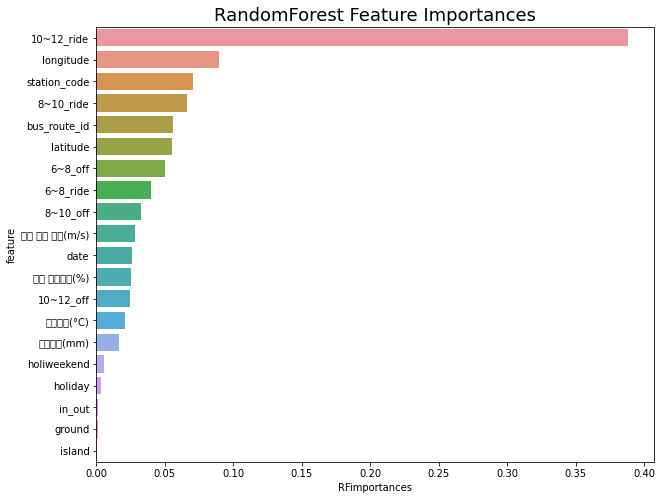

In [ ]:
plt.figure(figsize=(10, 8))
importances.sort_values('RFimportances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
sns.barplot(x='RFimportances', y='feature', data=importances)
plt.title('RandomForest Feature Importances', fontsize=18)
plt.show()

(한글 깨짐, seaborn 패키지 사용으로 오류 발생 시 첨부 이미지 참고 바랍니다.)

![img](https://ifh.cc/g/CaVCBo.png)

Feature Importances를 보면 10~12_ride 변수가 가장 <font style="font-weight : bold">중요⭐</font>하다고 말해주고 있습니다.
<br/>반대로 island 변수는 별로 중요하지 않네요!

<font style="font-weight : bold">외부데이터들이 모두 낮은 중요도를 가지고 있습니다. </font>

상관관계 그래프를 그려서 더 자세히 살펴봅시다.

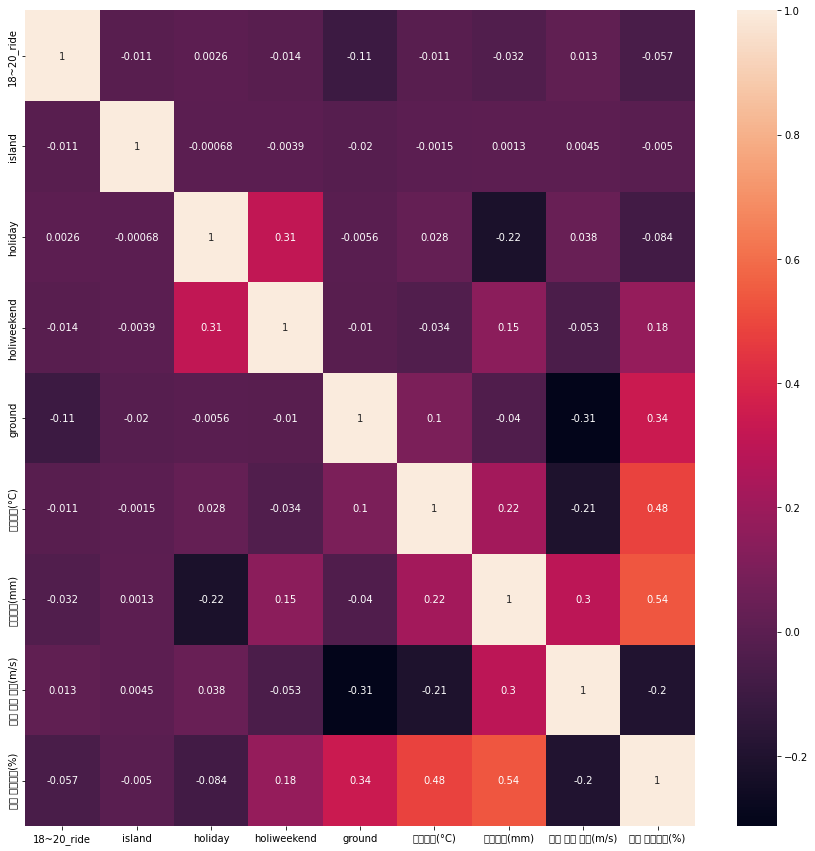

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(train[['18~20_ride','island','holiday','holiweekend' ,'ground','평균기온(°C)','일강수량(mm)','최대 순간 풍속(m/s)','최소 상대습도(%)']].corr(method='spearman'), annot = True)
plt.show()

변수 중요도와 상관분석을 비교해보니, 기존데이터만 쓰는 것이 정확도가 더 높을 가능성이 있을거 같군요! 

그런데 기존 데이터 중에서도, 변수중요도가 낮은 column이 있습니다...😥 'in_out' 인데요.. 기존 데이터에서 이 아이를 빼면 더 좋은 정확도를 얻을 수 있지않을까! 하는 생각이 들었습니다.

그래서 최종 모델에 사용할 x 변수는 기존 데이터에서 'in_out'을 뺀 나머지 column들 입니다.

그럼 RandomForest 모델로 최종 모델을 완성해봅시다.

In [ ]:
x = train[['10~12_ride','longitude', 'station_code','8~10_ride', 'bus_route_id', 'latitude', '6~8_off', '6~8_ride','8~10_off','date','10~12_off']]

y = train['18~20_ride']

In [ ]:
test = test[['10~12_ride','longitude', 'station_code','8~10_ride', 'bus_route_id', 'latitude', '6~8_off', '6~8_ride','8~10_off','date','10~12_off']]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y)

# **3. 최종 모델링**

RandomForest가 가장 높은 정확도를 가졌기 때문에 
<br/>지난 시간에 학습했던 RandomForest 모델을 사용하여 마지막 모델링을 진행해 보도록 하겠습니다.(화이팅💦) 

In [ ]:
# RandomForestRegressor 객체 호출
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor()

In [ ]:
# GRIDSEARCH를 이용한 최적화
params = {
    'n_estimators':(100, 200),
    'max_depth' : (5, 8),
    'min_samples_leaf' : (8, 18),
    'min_samples_split' : (8, 16)
}
model = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(model, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(x_train, y_train)
 
 
print(' Hyperparameter :', grid_cv.best_params_)
print('optimum prediction accuracy : {0:.4f}'.format(grid_cv.best_score_))

 Hyperparameter : {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 200}
optimum prediction accuracy : 0.5255


In [ ]:
# RandomForest 득점 모델 학습
model = RandomForestRegressor(random_state=0, max_depth=8, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=200, random_state=0)

In [ ]:
# train rmse
train_predict = model.predict(x_train)
print("RMSE : {}".format(math.sqrt(mean_squared_error(train_predict, y_train))) )

RMSE : 2.957288351254188


In [ ]:
# validation rmse
valid_predict = model.predict(x_val)
print("RMSE : {}".format(math.sqrt(mean_squared_error(valid_predict, y_val))))

RMSE : 3.147127423310097


In [ ]:
# training set 정확도 확인
print("training set accuracy:", model.score(x_train, y_train))

training set accuracy: 0.6074852811430818


In [ ]:
# validation set 정확도 확인
print("validation set accuracy:", model.score(x_val, y_val))

validation set accuracy: 0.5569919772340153


RandomForest Hyperparameter 튜닝을 한 결과 가장 높은 정확도를 보이는 것을 확인할 수 있습니다.

In [ ]:
# 학습된 모델을 이용해 결괏값 예측
predict = model.predict(test)
predict

array([11.58633089, 17.27333601,  3.60422954, ...,  0.14668842,
        0.14668842,  0.17320992])

In [ ]:
# 반올림
predict = predict.round(0)
predict

array([12., 17.,  4., ...,  0.,  0.,  0.])

# **5. 제출파일 생성**

지난 시간과 마찬가지로 train data, test data, validation data로 나눈 다음 학습은 진행하였습니다.
</br>이를 통한 Random Forest Model의 예측값으로 submissio의 18~20_ride 값을 채워봅시다.

In [ ]:
submission['18~20_ride'] = predict
submission['18~20_ride'] 

id
415423    12.0
415424    17.0
415425     4.0
415426    52.0
415427     3.0
          ... 
643588     0.0
643589     0.0
643590     0.0
643591     0.0
643592     0.0
Name: 18~20_ride, Length: 228170, dtype: float64

지난 시간에 설명드렸 듯이 to_csv 메소드는 </br>데이터 프레임 객체의 내용을 csv 파일 형태로 만들어서 저장해 주는 기능입니다.
</br>index를 포함시키지 않고 데이터를 저장하기 위해서는 </br>to_csv(inedx=False)로 지정해서 데이터를 저장해주면 됩니다.

</br>이제 제출용 파일인 submission.csv를 저장해봅시다. 

In [ ]:
submission[['18~20_ride']].to_csv('submission.csv')

# **6.인사이트 도출**

In [ ]:
submission['18~20_ride'].describe()

count    228170.000000
mean          1.257904
std           3.744052
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         137.000000
Name: 18~20_ride, dtype: float64

최소 0명에서 최대 137명으로 버스 정류장 승객 수요가 크게 차이납니다. </br>
평균이 1.25, 표준편차가 3.7이므로 평균에 몰려있습니다. 

모델을 생성하여 예측한 결과를 요약하여 관찰했을 때, 18시에서 20시 사이에는 보통 0~1명이 버스에 탑승합니다. 

지금까지 열심히 따라와 주셔서 감사합니다!🌊